In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment

from kmeans_explainer import CFE_explainer


In [2]:
DATASET_NAME = "adult"   # <- change to: "student", "credit_MARRIAGE", "bank_married_single"
dataset_social = "adult" #<- change to: "student", "credit", "bank"
DATASETS = {
    "adult": {
        "csv_path": "adult_preprocessed.csv",
        "feature_cols": [
            'age', 'final-weight', 'education-num', 'marital-status', 'occupation',
            'relationship', 'capital-gain', 'hours-per-week', 'native-country', 'income'
        ],
        "sensitive_col": "sex",   
        "k_default": 7,
        "balance_data_dir": "output",                
        "unfair_centers_dir": "unfair_centers_adult",
        "fair_centers_dir": "fair_centers_adult",
        "balance_prefix": "adult",                   
    },

    "credit_MARRIAGE": {
        "csv_path": "credit_preprocessed.csv",       
        "feature_cols": [
            'LIMIT_BAL', 'SEX', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
            'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
            'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'MARRIAGE'
        ],
        "sensitive_col": "MARRIAGE",                 
        "k_default": 5,
        "balance_data_dir": "output",        
        "unfair_centers_dir": "unfair_centers/unfair_centers_credit",
        "fair_centers_dir": "fair_centers_credit",
        "balance_prefix": "credit_MARRIAGE",
    },

    "student": {
        "csv_path": "student_preprocessed.csv",      
        "feature_cols": [
            'school', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
            'Mjob', 'Fjob', 'traveltime', 'studytime', 'failures', 'schoolsup',
            'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
            'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
            'absences', 'sex'
        ],
        "sensitive_col": "sex",
        "k_default": 5,
        "balance_data_dir": "output",        
        "unfair_centers_dir": "unfair_centers/unfair_centers_student",
        "fair_centers_dir": "fair_centers_student",
        "balance_prefix": "student",
    },

    "bank_married_single": {
        "csv_path": "bank_preprocessed.csv",
        "feature_cols": [
            'age', 'balance', 'duration', 'marital'
        ],
        "sensitive_col": "marital",
        "k_default": 5,
        "balance_data_dir": "output",           
        "unfair_centers_dir": "unfair_centers/unfair_centers_bank",
        "fair_centers_dir": "fair_centers_bank",
        "balance_prefix": "bank_married_single",
    },
}

if DATASET_NAME not in DATASETS:
    raise ValueError(f"Unknown DATASET_NAME: {DATASET_NAME}")

cfg = DATASETS[DATASET_NAME]

feature_cols      = cfg["feature_cols"]
sensitive_col     = cfg["sensitive_col"]
k_default         = cfg["k_default"]
balance_data_dir  = cfg["balance_data_dir"]
dir_unfair_centers = cfg["unfair_centers_dir"]
dir_fair_centers   = cfg["fair_centers_dir"]
balance_prefix     = cfg["balance_prefix"]

print("Using dataset:", DATASET_NAME)
print("Feature columns:", feature_cols)
print("Sensitive attribute:", sensitive_col)
print("Default k:", k_default)


Using dataset: adult
Feature columns: ['age', 'final-weight', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country', 'income']
Sensitive attribute: sex
Default k: 7


In [5]:
def projection_distance(x, c_i, c_l):
    """
    Distance of x to the separating hyperplane between centers c_i and c_l,
    using the projection formula.
    """
    m_il = (c_i + c_l) / 2.0
    numerator = np.abs(np.dot((x - m_il), (c_l - c_i)))
    denominator = np.linalg.norm(c_l - c_i)
    if denominator == 0.0:
        return 0.0
    return numerator / denominator


def align_fair_to_unfair(unfair_labels: np.ndarray,
                         fair_labels: np.ndarray):
    """
    Align fair_labels to unfair_labels using Hungarian algorithm
    on the contingency table (maximizing overlap).

    Returns:
        aligned_fair : np.ndarray (same shape as fair_labels)
        label_map    : dict {original_fair_label -> aligned_unfair_label}
    """
    unfair_labels = np.asarray(unfair_labels, dtype=int)
    fair_labels   = np.asarray(fair_labels, dtype=int)
    assert unfair_labels.shape == fair_labels.shape

    k_unfair = int(unfair_labels.max()) + 1
    k_fair   = int(fair_labels.max()) + 1

    conf_matrix = np.zeros((k_unfair, k_fair), dtype=int)
    for a in range(k_unfair):
        for b in range(k_fair):
            conf_matrix[a, b] = np.sum((unfair_labels == a) & (fair_labels == b))

    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    label_map = {col: row for row, col in zip(col_ind, row_ind)}
    aligned_fair = np.array([label_map[l] for l in fair_labels], dtype=int)
    return aligned_fair, label_map


def evaluate_alignment(unfair_labels: np.ndarray,
                       fair_labels: np.ndarray,
                       group: np.ndarray | None = None):
    """
    Unified evaluation function for ALL methods (Balance, Social-Fair/Fair-Lloyd, etc.).

    Computes:
      - global NMI cost = 1 - NMI(unfair, fair)
      - total misaligned count (after aligning fair → unfair)
      - total misaligned rate
      - optional: per-group NMI cost and misaligned count

    Args:
        unfair_labels : np.ndarray (N,), 0-based cluster IDs (unfair)
        fair_labels   : np.ndarray (N,), 0-based cluster IDs (fair)
        group         : optional np.ndarray (N,) with binary group attribute (e.g. sex ∈ {0,1})

    Returns:
        dict with:
            'nmi_cost_total'
            'misaligned_count_total'
            'misaligned_rate_total'
            'aligned_fair'
            'label_map'
        and if group is not None:
            'nmi_cost_group'         : dict[group_value -> NMI cost]
            'misaligned_count_group' : dict[group_value -> count]
    """
    unfair_labels = np.asarray(unfair_labels, dtype=int)
    fair_labels   = np.asarray(fair_labels, dtype=int)
    assert unfair_labels.shape == fair_labels.shape

    # 1. label alignment (fair -> unfair)
    aligned_fair, label_map = align_fair_to_unfair(unfair_labels, fair_labels)

    # 2. NMI cost (1 - NMI)
    nmi_cost_total = 1.0 - normalized_mutual_info_score(unfair_labels, fair_labels)

    # 3. Misalignment after alignment
    mis_mask = (unfair_labels != aligned_fair)
    misaligned_count_total = int(mis_mask.sum())
    misaligned_rate_total  = float(mis_mask.mean())

    result = {
        "nmi_cost_total": nmi_cost_total,
        "misaligned_count_total": misaligned_count_total,
        "misaligned_rate_total": misaligned_rate_total,
        "aligned_fair": aligned_fair,
        "label_map": label_map,
    }

    # 4. Optional per-group metrics
    if group is not None:
        group = np.asarray(group)
        assert group.shape == unfair_labels.shape

        nmi_cost_group = {}
        misaligned_count_group = {}

        for g in np.unique(group):
            idx = (group == g)
            if idx.sum() == 0:
                continue

            nmi_cost_g = 1.0 - normalized_mutual_info_score(
                unfair_labels[idx], fair_labels[idx]
            )
            misaligned_count_g = int(np.sum(unfair_labels[idx] != aligned_fair[idx]))

            nmi_cost_group[int(g)] = nmi_cost_g
            misaligned_count_group[int(g)] = misaligned_count_g

        result["nmi_cost_group"] = nmi_cost_group
        result["misaligned_count_group"] = misaligned_count_group

    return result


In [7]:
seeds    = list(range(10))
k_values = list(range(4, 11))
n_seeds  = len(seeds)
n_k      = len(k_values)

nmi_cost_total_balance   = np.full((n_seeds, n_k), np.nan)
nmi_cost_group0_balance  = np.full((n_seeds, n_k), np.nan)
nmi_cost_group1_balance  = np.full((n_seeds, n_k), np.nan)
misaligned_total_balance = np.full((n_seeds, n_k), np.nan)
misaligned_g0_balance    = np.full((n_seeds, n_k), np.nan)
misaligned_g1_balance    = np.full((n_seeds, n_k), np.nan)

for i, seed in enumerate(seeds):
    for j, k in enumerate(k_values):
        csv_path = os.path.join(balance_data_dir, f"{balance_prefix}_{seed}_k={k}.csv")
        if not os.path.exists(csv_path):
            print(f"[BALANCE] Missing: {csv_path}")
            continue

        df = pd.read_csv(csv_path)

        unfair = df["unfair_label"].to_numpy()
        fair   = df["fair_label"].to_numpy()
        group  = df[sensitive_col].to_numpy()  # assumed binary

        metrics = evaluate_alignment(unfair_labels=unfair,
                                     fair_labels=fair,
                                     group=group)

        nmi_cost_total_balance[i, j]   = metrics["nmi_cost_total"]
        misaligned_total_balance[i, j] = metrics["misaligned_count_total"]

        nmi_g = metrics["nmi_cost_group"]
        mis_g = metrics["misaligned_count_group"]

        if 0 in nmi_g:
            nmi_cost_group0_balance[i, j]  = nmi_g[0]
            misaligned_g0_balance[i, j]    = mis_g[0]
        if 1 in nmi_g:
            nmi_cost_group1_balance[i, j]  = nmi_g[1]
            misaligned_g1_balance[i, j]    = mis_g[1]

# Aggregate over seeds
mean_nmi_total_balance = np.nanmean(nmi_cost_total_balance, axis=0)
std_nmi_total_balance  = np.nanstd(nmi_cost_total_balance, axis=0)

mean_nmi_g0_balance = np.nanmean(nmi_cost_group0_balance, axis=0)
std_nmi_g0_balance  = np.nanstd(nmi_cost_group0_balance, axis=0)

mean_nmi_g1_balance = np.nanmean(nmi_cost_group1_balance, axis=0)
std_nmi_g1_balance  = np.nanstd(nmi_cost_group1_balance, axis=0)

mean_mis_total_balance = np.nanmean(misaligned_total_balance, axis=0)
std_mis_total_balance  = np.nanstd(misaligned_total_balance, axis=0)

mean_mis_g0_balance = np.nanmean(misaligned_g0_balance, axis=0)
std_mis_g0_balance  = np.nanstd(misaligned_g0_balance, axis=0)

mean_mis_g1_balance = np.nanmean(misaligned_g1_balance, axis=0)
std_mis_g1_balance  = np.nanstd(misaligned_g1_balance, axis=0)

rows = []
for j, k in enumerate(k_values):
    rows.append({
        "k": k,
        "nmi_cost_total_mean":   mean_nmi_total_balance[j],
        "nmi_cost_total_std":    std_nmi_total_balance[j],
        "nmi_cost_g0_mean":      mean_nmi_g0_balance[j],
        "nmi_cost_g0_std":       std_nmi_g0_balance[j],
        "nmi_cost_g1_mean":      mean_nmi_g1_balance[j],
        "nmi_cost_g1_std":       std_nmi_g1_balance[j],
        "misaligned_total_mean": mean_mis_total_balance[j],
        "misaligned_total_std":  std_mis_total_balance[j],
        "misaligned_g0_mean":    mean_mis_g0_balance[j],
        "misaligned_g0_std":     std_mis_g0_balance[j],
        "misaligned_g1_mean":    mean_mis_g1_balance[j],
        "misaligned_g1_std":     std_mis_g1_balance[j],
    })

summary_balance = pd.DataFrame(rows)
summary_balance_path = f"nmi_misalignment_stats_balance_method_{DATASET_NAME}_clean.csv"
summary_balance.to_csv(summary_balance_path, index=False)
print("Saved:", summary_balance_path)

Saved: nmi_misalignment_stats_balance_method_adult_clean.csv


In [8]:
# -------------------------
# SOCIAL-FAIR / FAIR-LLOYD: alignment metrics
# -------------------------
results_dir = "cost_seeds"

nmi_cost_total_sf  = np.full((n_seeds, n_k), np.nan)
nmi_cost_g0_sf     = np.full((n_seeds, n_k), np.nan)
nmi_cost_g1_sf     = np.full((n_seeds, n_k), np.nan)

misaligned_total_sf = np.full((n_seeds, n_k), np.nan)
misaligned_g0_sf    = np.full((n_seeds, n_k), np.nan)
misaligned_g1_sf    = np.full((n_seeds, n_k), np.nan)

for i, seed in enumerate(seeds):
    for j, k in enumerate(k_values):
        mat_path = os.path.join(results_dir, f"full_results_seed_{seed}_k_{k}_{dataset_social}.mat")
        if not os.path.exists(mat_path):
            print(f"[Social-Fair] Missing: {mat_path}")
            continue

        try:
            data = scipy.io.loadmat(mat_path)

            unfair = data["clusteringN"].flatten() - 1
            fair   = data["fair_clustering_combined"].flatten() - 1

            females = data["data_females"]
            males   = data["data_males"]
            n_females = females.shape[0]
            n_males   = males.shape[0]

            # group: 0 for first block, 1 for second block
            group = np.zeros(unfair.shape[0], dtype=int)
            group[n_females:] = 1

            metrics = evaluate_alignment(unfair_labels=unfair,
                                         fair_labels=fair,
                                         group=group)

            nmi_cost_total_sf[i, j]   = metrics["nmi_cost_total"]
            misaligned_total_sf[i, j] = metrics["misaligned_count_total"]

            nmi_g = metrics["nmi_cost_group"]
            mis_g = metrics["misaligned_count_group"]

            if 0 in nmi_g:
                nmi_cost_g0_sf[i, j]  = nmi_g[0]
                misaligned_g0_sf[i, j] = mis_g[0]
            if 1 in nmi_g:
                nmi_cost_g1_sf[i, j]  = nmi_g[1]
                misaligned_g1_sf[i, j] = mis_g[1]

        except Exception as e:
            print(f"[Social-Fair] Error seed={seed}, k={k}: {e}")
            continue

mean_nmi_total_sf = np.nanmean(nmi_cost_total_sf, axis=0)
std_nmi_total_sf  = np.nanstd(nmi_cost_total_sf, axis=0)

mean_nmi_g0_sf = np.nanmean(nmi_cost_g0_sf, axis=0)
std_nmi_g0_sf  = np.nanstd(nmi_cost_g0_sf, axis=0)

mean_nmi_g1_sf = np.nanmean(nmi_cost_g1_sf, axis=0)
std_nmi_g1_sf  = np.nanstd(nmi_cost_g1_sf, axis=0)

mean_mis_total_sf = np.nanmean(misaligned_total_sf, axis=0)
std_mis_total_sf  = np.nanstd(misaligned_total_sf, axis=0)

mean_mis_g0_sf = np.nanmean(misaligned_g0_sf, axis=0)
std_mis_g0_sf  = np.nanstd(misaligned_g0_sf, axis=0)

mean_mis_g1_sf = np.nanmean(misaligned_g1_sf, axis=0)
std_mis_g1_sf  = np.nanstd(misaligned_g1_sf, axis=0)

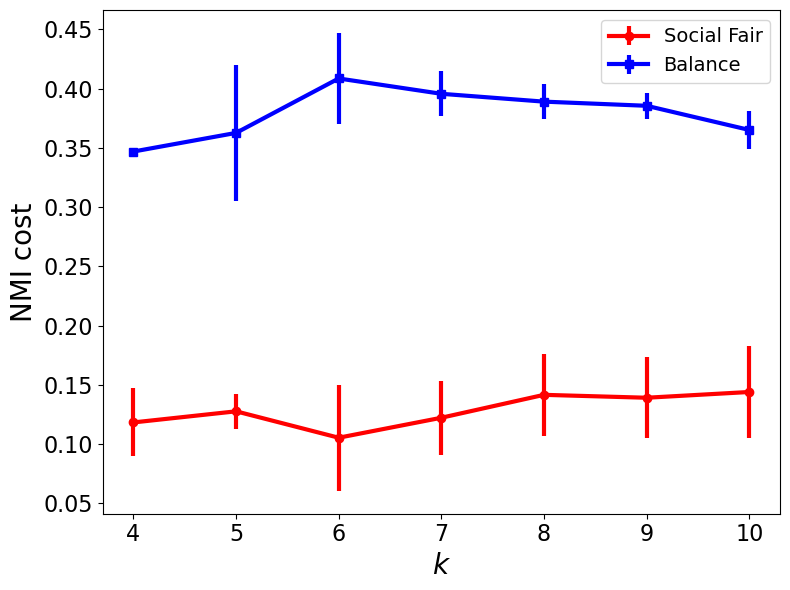

In [10]:
k_array = np.array(list(k_values))

plt.figure(figsize=(8, 6))
plt.errorbar(
    k_array, mean_nmi_total_sf, yerr=std_nmi_total_sf,
    marker='o', linewidth=3, label='Social Fair', color='red'
)
plt.errorbar(
    summary_balance["k"].values,
    summary_balance["nmi_cost_total_mean"].values,
    yerr=summary_balance["nmi_cost_total_std"].values,
    marker='s', linewidth=3, label='Balance', color='blue'
)

plt.xlabel(r"$k$", fontsize=20)
plt.ylabel("NMI cost", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f"nmi_cost_per_cluster_{DATASET_NAME}_sf_vs_balance.pdf")
plt.show()


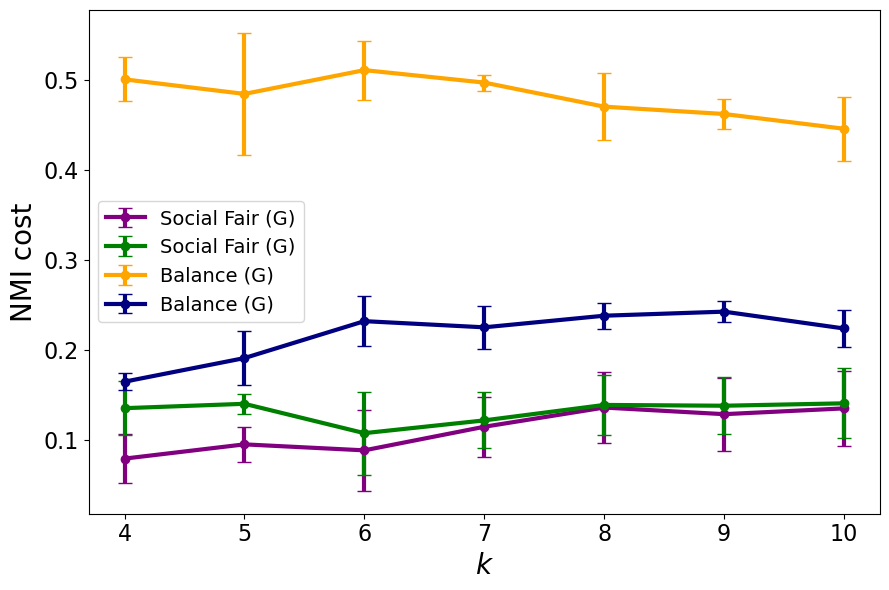

In [12]:
# Build unified NMI stats dataframe
rows = []

for idx, k in enumerate(k_values):
    rows.append({
        "method": "social_fair",
        "sex": 0,
        "k": int(k),
        "mean": mean_nmi_g0_sf[idx],
        "std":  std_nmi_g0_sf[idx],
    })
    rows.append({
        "method": "social_fair",
        "sex": 1,
        "k": int(k),
        "mean": mean_nmi_g1_sf[idx],
        "std":  std_nmi_g1_sf[idx],
    })

for _, r in summary_balance.iterrows():
    rows.append({
        "method": "balance",
        "sex": 0,
        "k": int(r["k"]),
        "mean": r["nmi_cost_g0_mean"],
        "std":  r["nmi_cost_g0_std"],
    })
    rows.append({
        "method": "balance",
        "sex": 1,
        "k": int(r["k"]),
        "mean": r["nmi_cost_g1_mean"],
        "std":  r["nmi_cost_g1_std"],
    })

nmi_stats_all = pd.DataFrame(rows)

methods = ["social_fair", "balance"]
method_labels = {"social_fair": "Social Fair", "balance": "Balance"}
sex_labels = {0: "Group 0", 1: "Group 1"}   # or "Female", "Male" if you want

colors = {
    ("social_fair", 0): "purple",
    ("social_fair", 1): "green",
    ("balance", 0): "orange",
    ("balance", 1): "navy",
}

plt.figure(figsize=(9, 6))

for method in methods:
    for sex in [0, 1]:
        sub = nmi_stats_all[
            (nmi_stats_all["method"] == method) &
            (nmi_stats_all["sex"] == sex)
        ].sort_values("k")

        if sub.empty:
            continue

        plt.errorbar(
            sub["k"], sub["mean"], yerr=sub["std"],
            label=f"{method_labels[method]} ({sex_labels[sex][0]})",
            marker="o", linewidth=3, capsize=5,
            color=colors[(method, sex)]
        )

plt.xlabel(r"$k$", fontsize=20)
plt.ylabel("NMI cost", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f"nmi_cost_all_methods_all_groups_{DATASET_NAME}.pdf")
plt.show()

In [ ]:
# -------------------------
# COUNTERFACTUALS: BALANCE
# -------------------------
d_eps_center_dist_ratio = 1.0

feature_changes_balance = []  
all_cf_pairs = []  

for seed in seeds:
    for k in k_values:
        csv_path = os.path.join(balance_data_dir, f"{balance_prefix}_{seed}_k={k}.csv")
        if not os.path.exists(csv_path):
            print(f"[BALANCE-CF] Missing file: {csv_path}")
            continue

        df = pd.read_csv(csv_path)

        unfair = df["unfair_label"].to_numpy()
        fair   = df["fair_label"].to_numpy()
        group  = df[sensitive_col].to_numpy()

        aligned_fair, label_map = align_fair_to_unfair(unfair, fair)
        df["aligned_fair"] = aligned_fair

        unfair_centers_path = os.path.join(
            dir_unfair_centers, f"{DATASET_NAME}_unfair_centers_seed{seed}_k{k}.csv"
        )
        fair_centers_path = os.path.join(
            dir_fair_centers, f"{DATASET_NAME}_fair_centers_seed{seed}_k{k}.csv"
        )

        if not (os.path.exists(unfair_centers_path) and os.path.exists(fair_centers_path)):
            print(f"[BALANCE-CF] Missing centers for seed={seed}, k={k}")
            continue

        df_unfair_centers = pd.read_csv(unfair_centers_path)
        df_fair_centers   = pd.read_csv(fair_centers_path)

        cols_unfair = df_unfair_centers.columns.difference(["cluster_id", "type", "seed", "k"])
        cols_fair = df_fair_centers.columns.difference(["cluster_id", "type", "seed", "k"])
        mask = np.ones(len(cols_fair), dtype=int)

        misaligned_df = df[df["aligned_fair"] != df["unfair_label"]].copy()
        if misaligned_df.empty:
            print(f"[BALANCE-CF] No misaligned points for seed={seed}, k={k}")
            continue

        n_mis = len(misaligned_df)

        for _, row in misaligned_df.iterrows():
            factual = row[cols_fair].values.astype(float)
            g_val   = int(row[sensitive_col])
            source_label = int(row["unfair_label"])
            target_label = int(row["aligned_fair"])

            center_unfair = df_unfair_centers.loc[
                df_unfair_centers["cluster_id"] == source_label, cols_unfair
            ].values.flatten()

            center_fair = df_fair_centers.loc[
                df_fair_centers["cluster_id"] == target_label, cols_fair
            ].values.flatten()

            explainer = CFE_explainer(center_unfair, center_fair)
            z_opt = explainer.compute_counterfactual(factual, mask, d_eps_center_dist_ratio)

            # ---- NEW: store per-feature absolute change |cf - factual| ----
            diff = np.abs(z_opt - factual)
            feature_changes_balance.append(diff)
            # --------------------------------------------------------------

            d = projection_distance(factual, center_unfair, center_fair) / n_mis


            # inside BALANCE CF loop, after computing z_opt:
            all_cf_pairs.append({
                "method": "balance",
                "seed":   seed,
                "k":      k,
                "sex":    int(row[sensitive_col]),   # or df["sex"], etc.
                "factual": factual.copy(),           # np.array of features
                "cf":      z_opt.copy(),             # np.array of features
            })
df_cf_balance = pd.DataFrame(all_cf_pairs)
df_cf_balance_path = f"cf_cost_balance_{DATASET_NAME}.csv"
df_cf_balance.to_csv(df_cf_balance_path, index=False)
print("Saved:", df_cf_balance_path)


In [ ]:
import os
import numpy as np
import pandas as pd

# -------------------------
# COUNTERFACTUALS: SOCIAL-FAIR
# -------------------------
mask = None                   
d_eps_center_dist_ratio = 1.0

feature_changes_social = []   
for seed in seeds:
    for k in k_values:
        mat_path = os.path.join(results_dir, f"full_results_seed_{seed}_k_{k}_{dataset_social}.mat")
        if not os.path.exists(mat_path):
            print(f"[SOCIAL-CF] Missing: {mat_path}")
            continue

        try:
            data = scipy.io.loadmat(mat_path)

            unfair = data["clusteringN"].flatten()              
            fair   = data["fair_clustering_combined"].flatten()  

            centersN  = data["centersN"]   
            centersNF = data["centersNF"]  
            females = data["data_females"]
            males   = data["data_males"]

            n_females = females.shape[0]
            n_males   = males.shape[0]

            X_all = np.vstack([females, males])

            if mask is None:
                mask = np.ones(X_all.shape[1], dtype=int)

            sex_vec = np.concatenate([
                np.zeros(n_females, dtype=int),
                np.ones(n_males,   dtype=int),
            ])

            unfair = unfair - 1
            fair   = fair   - 1

            aligned_fair, label_map = align_fair_to_unfair(unfair, fair)

            # misaligned indices after alignment
            mis_mask = (unfair != aligned_fair)
            mis_idx = np.where(mis_mask)[0]
            if mis_idx.size == 0:
                print(f"[SOCIAL-CF] No misaligned points for seed={seed}, k={k}")
                continue

            n_mis = mis_idx.size

            for idx in mis_idx:
                factual = X_all[idx, :].astype(float)
                s_val   = int(sex_vec[idx])

                source_label = int(unfair[idx])
                target_label = int(aligned_fair[idx])

                center_unfair = centersN[source_label]
                center_fair   = centersNF[target_label]

                explainer = CFE_explainer(center_unfair, center_fair)
                z_opt = explainer.compute_counterfactual(factual, mask, d_eps_center_dist_ratio)

                # distance for CF cost
                d = projection_distance(factual, center_unfair, center_fair) / n_mis

                # store CF pair for later plots
                all_cf_pairs.append({
                    "method": "social_fair",
                    "seed":   seed,
                    "k":      k,
                    "sex":    s_val,           
                    "source_cluster": source_label,
                    "target_cluster": target_label,
                    "distance": d,
                    "factual": factual.copy(),
                    "cf":      z_opt.copy(),
                })

                diff = np.abs(z_opt - factual)
                feature_changes_social.append(diff)

            print(f"[SOCIAL-CF] OK seed={seed}, k={k}, misaligned={n_mis}")

        except Exception as e:
            print(f"[SOCIAL-CF] Error seed={seed}, k={k}: {e}")
            continue

df_cf_social = pd.DataFrame(all_cf_pairs)
df_cf_social_path = f"cf_cost_social_fair_{DATASET_NAME}.csv"
df_cf_social.to_csv(df_cf_social_path, index=False)
print("Saved:", df_cf_social_path)

feature_changes_social = np.array(feature_changes_social)
avg_change_social = feature_changes_social.mean(axis=0)

df_feature_change_social = pd.DataFrame({
    "Feature": cols_fair,              
    "Avg Absolute Change": avg_change_social
}).sort_values("Avg Absolute Change", ascending=False)

df_feature_change_social.to_csv(
    f"feature_contribution_social_fair_{DATASET_NAME}.csv",
    index=False
)
print("Saved feature contributions:", f"feature_contribution_social_fair_{DATASET_NAME}.csv")


In [ ]:
# -------------------------
# FEATURE CONTRIBUTION (Balance)
# -------------------------
if len(feature_changes_balance) == 0:
    print("No feature changes recorded for Balance; cannot compute feature contribution.")
else:
    # Stack all |cf - factual| vectors into a matrix
    feature_changes_balance = np.vstack(feature_changes_balance)   # shape: (num_cfs, num_features)

    # Average absolute change per feature
    avg_change_balance = np.mean(feature_changes_balance, axis=0)

    df_feature_change_balance = (
        pd.DataFrame({
            "Feature": cols_fair,
            "Avg Absolute Change": avg_change_balance
        })
        .sort_values("Avg Absolute Change", ascending=True)
    )

    # Horizontal bar plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(
        df_feature_change_balance["Feature"],
        df_feature_change_balance["Avg Absolute Change"],
        color="#FF0051"   # different color from Social-Fair if you like
    )

    max_val = df_feature_change_balance["Avg Absolute Change"].max()

    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.01 * max_val,
            bar.get_y() + bar.get_height() / 2,
            f"+{width:.2f}",
            va="center",
            fontsize=20
        )

    plt.title(f"Feature Contribution (Balance, {DATASET_NAME})", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"feature_contribution_balance_{DATASET_NAME}.pdf",
                format="pdf", bbox_inches="tight")
    plt.show()


In [ ]:
# -------------------------
# FEATURE CONTRIBUTION (Social-Fair)
# -------------------------
if len(feature_changes_social) == 0:
    print("No feature changes recorded for Social-Fair; cannot compute feature contribution.")
else:
    feature_changes_social = np.vstack(feature_changes_social)
    avg_change = np.mean(feature_changes_social, axis=0)

    df_feature_change = (
        pd.DataFrame({
            "Feature": cols_fair,
            "Avg Absolute Change": avg_change
        })
        .sort_values("Avg Absolute Change", ascending=True)
    )

    plt.figure(figsize=(12, 8))
    bars = plt.barh(
        df_feature_change["Feature"],
        df_feature_change["Avg Absolute Change"],
        color="#FF0051"
    )

    max_val = df_feature_change["Avg Absolute Change"].max()

    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.01 * max_val,
            bar.get_y() + bar.get_height() / 2,
            f"+{width:.2f}",
            va="center",
            fontsize=20
        )

    plt.title(f"Feature Contribution (Social-Fair, {DATASET_NAME})", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"feature_contribution_social_fair_{DATASET_NAME}.pdf",
                format="pdf", bbox_inches="tight")
    plt.show()

In [ ]:
chosen_seed = 0     
chosen_k = 7        

feature_labels = {f: f for f in feature_cols}  # plain feature names

methods_plot = ["balance", "social_fair"]
method_pretty = {
    "balance": "Balance",
    "social_fair": "Social Fair",
}

for method in methods_plot:
    for group_value, group_label in [(0, "female"), (1, "male")]:
        
        records = []

        # Build data only for chosen seed + k + group
        for rec in all_cf_pairs:
            if rec["method"] != method:
                continue
            if rec["seed"] != chosen_seed:
                continue
            if rec["k"] != chosen_k:
                continue
            if rec["sex"] != group_value:
                continue

            factual = rec["factual"]
            cf      = rec["cf"]

            feat_index = {name: idx for idx, name in enumerate(cols_fair)}

            for feat in cols_fair:
                idx = feat_index[feat]
                f_val = factual[idx]
                delta = cf[idx] - factual[idx]

                records.append({
                    "Feature": feature_labels[feat],
                    "Delta": delta,
                    "FactualValue": f_val,
                })

        if not records:
            print(f"No records for method={method}, seed={chosen_seed}, k={chosen_k}, group={group_label}")
            continue

        df_plot = pd.DataFrame(records)

        feature_order = (
            df_plot.groupby("Feature")["Delta"]
            .apply(lambda x: np.mean(np.abs(x)))
            .sort_values(ascending=False)
            .index
            .tolist()
        )

        vmin = df_plot["FactualValue"].min()
        vmax = df_plot["FactualValue"].max()
        cmap = plt.cm.plasma
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

        plt.figure(figsize=(8,12))
        ax = sns.stripplot(
            data=df_plot,
            x="Delta",
            y="Feature",
            hue="FactualValue",
            palette=cmap,
            dodge=False,
            jitter=0.15,
            size=12,
            alpha=0.9,
            order=feature_order,
        )

        # Colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.ax.tick_params(labelsize=18)

        ax.set_ylabel("Feature", fontsize=22)
        ax.set_xlabel("Delta", fontsize=22)

        ax.tick_params(axis="x", labelsize=20)
        ax.tick_params(axis="y", labelsize=20)

        if ax.legend_ is not None:
            ax.legend_.remove()

        delta_min = df_plot["Delta"].min()
        delta_max = df_plot["Delta"].max()

        ax.axvline(x=0, color="red", linestyle="--", linewidth=1.5)

        sns.despine()
        plt.title(
            f"Explainability – {method_pretty[method]} ({group_label}, seed={chosen_seed}, k={chosen_k})",
            fontsize=22
        )
        plt.tight_layout()

        out_name = f"explainability_{method}_{group_label}_seed{chosen_seed}_k{chosen_k}.pdf"
        plt.savefig(out_name, format="pdf", bbox_inches="tight")
        plt.show()
        print("Saved:", out_name)
